# Analysing data from DBF files

## Step 1. Import required packages

In [1]:
# from https://gist.github.com/stevenworthington/3178163
ipak <- function(pkg){
    new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg))
        install.packages(new.pkg, dependencies = TRUE, repos = "http://cran.r-project.org")
    sapply(pkg, require, character.only = TRUE)
}

packages <- c("ggplot2", "grid", "gridExtra","reshape2")
suppressMessages(ipak(packages))

library(foreign)  

ggplot2      grid gridExtra  reshape2 
     TRUE      TRUE      TRUE      TRUE

## Step 2. Set variables

In [2]:
dbf_file <- "3656.dbf"
well_order <- c('A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B12', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10', 'D11', 'D12', 'E01', 'E02', 'E03', 'E04', 'E05', 'E06', 'E07', 'E08', 'E09', 'E10', 'E11', 'E12', 'F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'G01', 'G02', 'G03', 'G04', 'G05', 'G06', 'G07', 'G08', 'G09', 'G10', 'G11', 'G12', 'H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H08', 'H09', 'H10', 'H11', 'H12')

## Step 3. Import the dbf file

In [3]:
# Thanks to https://github.com/phonixor/MicroPlate
buffer <- suppressWarnings(read.dbf(dbf_file))
# everything is now in a big data frame  
#
# Measurement column names have the format M\d+ 
measurements <- grep  ("^M[[:digit:]]+$", colnames(buffer))

# CH column indicates data channels
# Rows with CH=[numeric] represent wells
# Rows with CH=t represent time (only measurement columns)
# Rows with CH=C represent temperature (only measurement colums)
channels <- buffer[,"CH"]

# WELLNUM column contains well names
wellNames <- as.character(buffer[channels=="1", "WELLNUM"]) 

content=as.character(buffer[channels=="1", "CONTENT"])
nofWells <- length(wellNames)
wellData <- buffer[channels=="1", measurements] 
timePoints <- as.numeric(buffer[channels=="t", measurements])
wellData <- t(wellData)
colnames(wellData) <- wellNames
row.names(wellData) <- timePoints

## Step 4. Run the fitting functions

In [4]:
#do_fit <- function( x, y ) tryCatch( nls( y ~ 0.0744 + Vmax*x/(Km+x), start=list(Vmax=max(y)-min(y),Km=10) ), error=function(x,y) { } )
do_fit <- function( x, y ) tryCatch( nls( y ~ 700 + Vmax*x/(Km+x), start=list(Vmax=max(y),Km=10) ), error=function(er) {} )
do_fit2 <- function( x, y ) tryCatch( lm( y ~ x ), error=function(x,y) { } )
do_fit3 <- function( x, y )  tryCatch( nls( y ~ A + B*(1-exp(-k*x)), start=list(A=min(y), B=max(y),k=0.001) ), error=function(x,y){NaN})
M <- apply(wellData, 2, function(z) do_fit(timePoints,z))
LI <- apply(wellData, 2, function(z) do_fit2(timePoints,z))
EP <- apply(wellData, 2, function(z) do_fit3(timePoints,z))

L <- sapply( LETTERS[1:8], function(x) sprintf( "%s%02d", x, 1:12 ) )
Vmax <- apply( L, c(1,2), function(x) try( coef(M[[x]])[1]) )
Km   <- apply( L, c(1,2), function(x) try( coef(M[[x]])[2]) )
lin   <- apply( L, c(1,2), function(x) try( coef(LI[[x]])[2]) )
nonlin   <- apply( L, c(1,2), function(x) try( coef(M[[x]])[1]/(coef(M[[x]])[2]*2)) )
expo   <- apply( L, c(1,2), function(x) tryCatch( coef(EP[[x]])[3] ,error=function(er){NaN}))

## [Output] Show the graphs

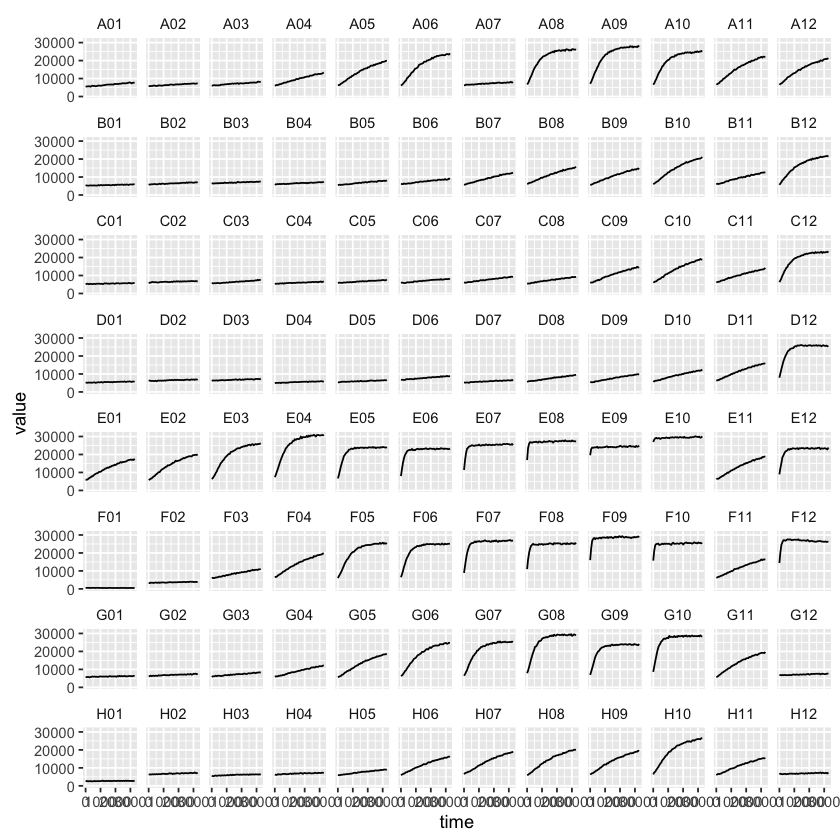

In [5]:
data2 = melt(data.frame(time=timePoints, wellData), id.vars="time")
data2$variable = factor(data2$variable, levels=well_order)
ggplot(data2, aes(time, value)) + 
  geom_line() +
  facet_wrap( ~ variable, nrow=8) + theme(strip.background = element_blank())

## [Output] Show table with values from exponential fit
Formula: y ~ A + B * (1 - exp(-k * x))

The table shows the values for k

In [6]:
table1 <- t(expo)
table1 <- as.data.frame(table1)
colnames(table1) <- c(1:12)
table1

,1,2,3,4,5,6,7,8,9,10,11,12
A,1.943427e-05,6.402287e-05,1.413776e-04,1.461336e-04,3.213474e-04,6.858955e-04,2.184204e-04,1.396662e-03,1.382825e-03,1.355008e-03,3.791606e-04,4.191787e-04
B,NaN,3.708246e-05,1.631340e-04,NaN,1.249984e-04,1.585456e-04,1.188945e-04,2.099292e-04,1.959959e-04,3.961663e-04,1.697149e-04,7.867976e-04
C,NaN,3.543228e-04,NaN,1.132305e-04,6.513878e-05,2.065449e-04,6.214576e-05,1.276751e-04,1.903277e-04,2.897296e-04,1.543528e-04,1.428736e-03
D,2.650858e-04,1.768671e-04,1.093205e-04,3.221069e-04,7.994458e-05,5.943365e-05,2.315336e-04,4.954043e-05,1.185482e-04,1.437914e-04,2.184525e-04,2.875280e-03
E,0.0003345344,0.0004365901,0.0010067267,0.0015242109,0.0030558323,0.0053616537,0.0080517915,0.0155193547,0.0176895446,NaN,0.0002572781,0.0049499415
F,0.0008612152,0.0002096971,0.0001096619,0.0003244429,0.0013103552,0.0023057594,0.0048860541,0.0082031340,0.0121636373,0.0145444785,0.0001783891,0.0117827110
G,3.127086e-04,1.844349e-04,3.379480e-05,1.040407e-04,3.172732e-04,7.531118e-04,1.467741e-03,2.094196e-03,2.714667e-03,3.322660e-03,3.559292e-04,8.016532e-05
H,0.0007929924,0.0001283848,0.0006177541,0.0005338413,0.0001585745,0.0002705146,0.0002628095,0.0004226964,0.0003479589,0.0008163560,0.0002031922,0.0001510915


## [Output] Show table with values from the linear fit
Formula: y ~ x 

The table shows the values for x

In [7]:
table2 <- t(lin)
table2 <- as.data.frame(table2)
colnames(table2) <- c(1:12)
table2

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.7163298,0.4856405,0.6021781,2.1929555,4.2730838,5.3232488,0.4799326,4.9296648,5.2360689,4.6727025,4.8781122,4.3919564
B,0.2002530,0.3847148,0.3172737,0.3764054,0.7949709,0.8940445,2.0480794,2.8910322,2.8319421,4.5613832,2.0647019,4.5228274
C,0.1547466,0.2454513,0.5954891,0.3549350,0.5049901,0.7277741,1.0323664,1.1560918,2.7627600,4.0737088,2.3323073,4.0900991
D,0.2010313,0.2478035,0.2870689,0.2995051,0.3201763,0.6669029,0.4021351,1.1457526,1.4351063,1.9637734,3.0270635,2.9462930
E,3.6086420,4.4043253,5.5354199,5.6585691,2.8258515,1.6658207,1.2650144,0.7343456,0.4151519,0.3400039,3.9469782,1.6305510
F,-0.0214094,0.1816395,1.5846575,4.0634097,5.0228227,3.6137227,2.1098894,1.1979216,0.8977177,0.7109939,3.2304313,0.4329340
G,0.1662217,0.3610951,0.6851775,1.9671183,4.0611500,5.4996248,4.7047199,4.4337482,2.9912060,3.0390504,4.2624149,0.2641888
H,0.0595775,0.2780183,0.2694609,0.3002799,0.9918102,3.1479780,3.8822505,4.4173744,4.0375059,5.7231700,2.9831761,0.2279715


## [Output] Show table with values from a non-linear fit
Formula: y ~ 700 + Vmax*x/(Km+x)

The table shows the values for Vmax/(Km*2)

In [8]:
table3 <- t(nonlin)
table3 <- as.data.frame(table3)
colnames(table3) <- c(1:12)
table3

,1,2,3,4,5,6,7,8,9,10,11,12
A,50.88673,96.09856,80.78596,13.35717,11.07222,16.16867,120.38996,34.20219,36.62370,32.74540,12.85907,14.17297
B,210.86298,134.23440,201.77816,132.15645,42.57269,43.85782,12.61067,11.63855,10.00048,11.79158,13.52978,18.17698
C,302.68735,217.82221,71.65741,112.25542,96.44161,54.29177,34.64766,22.88534,10.63392,10.71240,13.64720,34.18818
D,186.61111,250.59145,229.43400,116.03760,124.92426,89.67637,82.68189,27.13070,14.81850,13.66300,11.63166,92.20793
E,10.96299,11.68036,23.36653,43.80401,81.26444,180.98238,389.26480,1346.03595,2590.97576,4087.31240,10.64771,183.46872
F,-1.115413,64.667270,17.529790,12.197415,29.606487,59.398345,182.068063,383.102754,894.141873,1121.270985,10.726155,871.038402
G,257.99254,160.58392,72.30976,13.14845,9.99028,18.00388,34.64247,63.53632,72.96055,118.75136,10.93985,284.41544
H,132.44942,211.33413,129.41269,162.19942,35.25695,11.63794,11.55732,11.86024,12.13685,20.55654,10.79489,368.38724
